### Speech recognition with torchaudio

In this notebook we are going to create an audio classifier usin torchaudion.


### Installation of `torchaudio`

To install torchaudio for CPU you need to run the following command.

```shell
!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
```

Since we are working with google colab and GPU we are going to install it as follows:

```shell
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
```

In [ ]:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

### Imports

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import torchaudio, sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

torch.__version__, torchaudio.__version__

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


('1.7.0+cu101', '0.7.0')

### Device


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset

We are going to use [SpeechCommands](https://arxiv.org/abs/1804.03209) dataset which contains of 35 different commands spoken by different people. The dataset `SPEECHCOMMANDS` is a `torch.utils.data.Dataset` version of the dataset. In this dataset, all audio files are about 1 second long (and so about 16000 time frames long).

### Spitting the dataset into `train`, `test` and `validation`.

In [5]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

In [8]:
class SubsetSC(SPEECHCOMMANDS):
  def __init__(self, subset: str = None):
    super().__init__("./", download=True)

    def load_list(filename):
      filepath = os.path.join(self._path, filename)
      with open(filepath) as f:
        return [os.path.join(self._path, line.strip()) for line in f]

    if subset == "validation":
      self._walker = load_list("validation_list.txt")
    elif subset == "testing":
      self._walker = load_list("testing_list.txt")
    elif subset == "training":
      excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
      excludes = set(excludes)
      self._walker = [w for w in self._walker if w not in excludes]


### Creating train and test splits.

In [9]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

### Checking a single example.

In [10]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [12]:
waveform, label

(tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]),
 'backward')

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


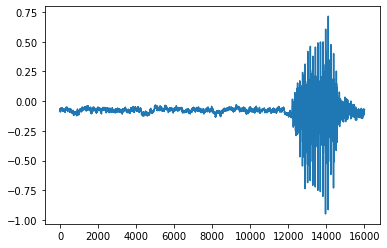

In [14]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())
plt.show()

### Checking the labels.

In [15]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

### Counting labels.

There are 35 labels in this dataset. Let's create a helper function that will visualize a single example with it's correcponding label in the dataset

In [26]:
def visualize_example(index):
  waveform, sample_rate, label, speaker_id, utterance_number = train_set[index]
  print(f"LABEL: {label}")

  ### Displaying a playable audio

  ipd.Audio(waveform.numpy(), rate=sample_rate)
  ipd.display()

  # plotting the waveform
  plt.plot(waveform.t().numpy())
  plt.show()
  

In [23]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

visualizing the first 5 examples and test them.

LABEL: backward


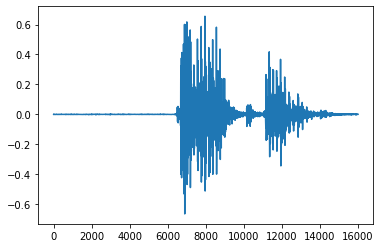

In [27]:
visualize_example(5)

> The dataset contains files that are not shuffled.

LABEL: dog


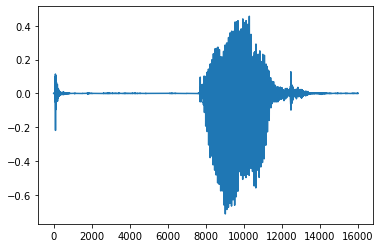

In [38]:
visualize_example(7188)

In [39]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

### Formatting the Data

For the waveform, we downsample the audio for faster processing without losing too much of the classification power.

We don’t need to apply other transformations here. It is common for some datasets though to have to reduce the number of channels (say from stereo to mono) by either taking the mean along the channel dimension, or simply keeping only one of the channels. Since SpeechCommands uses a single channel for audio, this is not needed here.

In [41]:
sample_rate

16000

In [42]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate,
                                           new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(waveform.numpy(), rate=sample_rate)

We are encoding each word using index in the list of labels.

In [43]:
def label_to_index(word):
  return torch.tensor(labels.index(word))

def index_to_label(index):
  return labels[index]

In [44]:
word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn on a lists of data point made of audio recordings and utterances into two batched tensors for the model, we implement a collate function which is used by the PyTorch DataLoader that allows us to iterate over a dataset by batches. In this colate function we are going to apply resampling and do the text encoding.

In [49]:
def pad_sequence(batch):
  batch = [item.t() for item in batch]
  batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
  return batch.permute(0, 2, 1)


def collate_fn(batch):
  tensors, targets = [], []

  for waveform, _, label, *_ in batch:
    tensors += [waveform]
    targets += [label_to_index(label)]

  tensors = pad_sequence(tensors)
  targets = torch.stack(targets)
  return tensors, targets


In [50]:
batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [90]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=True, # normally set t false
    # drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [91]:
next(iter(train_loader))

(tensor([[[ 9.1553e-05,  1.8921e-03,  3.7231e-03,  ...,  1.1597e-03,
            1.0376e-03,  1.2512e-03]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.2207e-04,
            1.2207e-04,  2.7466e-04]],
 
         [[ 0.0000e+00,  3.0518e-05,  6.1035e-05,  ..., -1.2207e-04,
           -6.1035e-05, -3.0518e-05]],
 
         ...,
 
         [[-1.1597e-03, -9.1553e-04, -2.2278e-03,  ..., -2.2278e-03,
           -2.7161e-03, -2.5024e-03]],
 
         [[ 2.7466e-04,  3.0518e-04,  3.3569e-04,  ...,  7.3242e-04,
            6.4087e-04,  5.7983e-04]],
 
         [[-3.0518e-05, -3.0518e-05, -3.0518e-05,  ...,  4.7272e-02,
            6.0059e-02,  6.8787e-02]]]),
 tensor([18, 12, 25, 23, 31, 10, 34,  3,  9, 28,  5, 17, 34, 30, 34, 32,  1,  5,
         25, 26, 12, 22, 12, 34, 13, 19,  7,  9, 13, 32, 33, 20, 34,  2,  8, 21,
         27, 16,  5, 26, 18, 27, 17, 13, 18, 34, 14,  9, 14, 30, 26,  8, 18, 21,
         23, 29, 20, 27, 10, 33, 32, 23, 19, 25,  7, 24, 18, 12, 30,  1, 25, 32,


### Defining the Network

We are going to use a Convolutional neural network to process the raw audio data.  Usually more advanced transforms are applied to the audio data, however CNNs can be used to accurately process the raw data. The specific architecture is modeled after the **M5** network architecture described in [this paper](https://arxiv.org/pdf/1610.00087.pdf).

In [92]:
waveform.shape

torch.Size([1, 16000])

In [138]:
class M5(nn.Module):
  def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
    super(M5, self).__init__()
    self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
    self.bn1 = nn.BatchNorm1d(n_channel)
    self.pool1 = nn.MaxPool1d(4)

    self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(n_channel)
    self.pool2 = nn.MaxPool1d(4)

    self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
    self.bn3 = nn.BatchNorm1d(2 * n_channel)
    self.pool3 = nn.MaxPool1d(4)

    self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
    self.bn4 = nn.BatchNorm1d(2 * n_channel)
    self.pool4 = nn.MaxPool1d(4)

    self.fc1 = nn.Linear(2 * n_channel, n_output)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.pool3(x)
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = self.pool4(x)
    x = F.avg_pool1d(x, x.shape[-1])
    x = x.permute(0, 2, 1)
    x = self.fc1(x)
    return F.log_softmax(x, dim=2)


In [139]:
model = M5(n_input=transformed.shape[0], n_output=len(labels)).to(device)
model

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

### Counting `model` parameters.

In [140]:
def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params, trainable_params = count_trainable_params(model)
print(f"Total number of paramaters: {n_params:,}\nTotal tainable parameters: {trainable_params:,}")

Total number of paramaters: 26,915
Total tainable parameters: 26,915


### Optimizer and Criterion

We will use the `Adam` optimizer with the weight decay of `0.0001` with a learning rate of `0.01` but we will use the `scheduler` to decrease it to `0.001` after every 20 epochs.

In [141]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

### The categorical accuracy function

This function will measure the accuracy with actual predictions and model predictions during training.


In [142]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

### Training and testing the Network

Now let's define our training function that will feed our training data into the model and perform backward propagation and optimization steps.

In [143]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [144]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [147]:
from tqdm import tqdm

In [148]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.008/2 [00:00<01:07, 33.92s/it]                

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.854132


  3%|▎         | 0.061333333333333316/2 [00:01<01:02, 32.04s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 2.941710


  6%|▌         | 0.11466666666666661/2 [00:03<01:02, 33.14s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.452315


  8%|▊         | 0.16800000000000012/2 [00:05<00:57, 31.22s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.165611


 11%|█         | 0.2213333333333337/2 [00:07<00:56, 31.93s/it] 

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.020693


 14%|█▎        | 0.274666666666667/2 [00:08<00:54, 31.41s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.880635


 16%|█▋        | 0.328/2 [00:10<00:52, 31.35s/it]             

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.597939


 19%|█▉        | 0.381333333333333/2 [00:12<00:52, 32.25s/it] 

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.602111


 22%|██▏       | 0.43466666666666604/2 [00:13<00:50, 31.99s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.441137


 24%|██▍       | 0.48799999999999905/2 [00:15<00:47, 31.11s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.307778


 27%|██▋       | 0.5413333333333329/2 [00:17<00:45, 30.88s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.339556


 30%|██▉       | 0.594666666666667/2 [00:18<00:43, 31.24s/it] 

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.276974


 32%|███▏      | 0.6480000000000011/2 [00:20<00:43, 32.51s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.262046


 35%|███▌      | 0.7013333333333353/2 [00:22<00:40, 31.42s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.186881


 38%|███▊      | 0.7546666666666694/2 [00:23<00:38, 30.84s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.254314


 40%|████      | 0.8080000000000035/2 [00:25<00:38, 32.17s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.389045


 43%|████▎     | 0.8613333333333376/2 [00:27<00:35, 30.96s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.043523


 50%|█████     | 1.0053333333333394/2 [00:31<00:28, 28.70s/it]


Test Epoch: 1	Accuracy: 6628/11005 (60%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.212359


 53%|█████▎    | 1.0586666666666713/2 [00:33<00:29, 31.68s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.056767


 56%|█████▌    | 1.1120000000000032/2 [00:34<00:28, 31.85s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.047772


 58%|█████▊    | 1.165333333333335/2 [00:36<00:25, 31.03s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.123228


 61%|██████    | 1.218666666666667/2 [00:38<00:24, 31.25s/it] 

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.136580


 64%|██████▎   | 1.271999999999999/2 [00:39<00:23, 31.82s/it] 

Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.066638


 66%|██████▋   | 1.3253333333333308/2 [00:41<00:20, 30.74s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.965958


 69%|██████▉   | 1.3786666666666627/2 [00:43<00:19, 30.78s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 1.096697


 72%|███████▏  | 1.4319999999999946/2 [00:44<00:17, 31.59s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.991484


 74%|███████▍  | 1.4853333333333265/2 [00:46<00:15, 30.72s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 1.143974


 77%|███████▋  | 1.5386666666666584/2 [00:48<00:14, 31.51s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 1.016132


 80%|███████▉  | 1.5919999999999903/2 [00:49<00:12, 31.51s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.895918


 82%|████████▏ | 1.6453333333333222/2 [00:51<00:10, 30.82s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 1.092318


 85%|████████▍ | 1.6986666666666541/2 [00:53<00:09, 30.57s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 1.006853


 88%|████████▊ | 1.751999999999986/2 [00:54<00:07, 31.29s/it] 

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.820516


 90%|█████████ | 1.805333333333318/2 [00:56<00:06, 31.63s/it] 

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.961983


 93%|█████████▎| 1.8586666666666498/2 [00:58<00:04, 31.62s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.837534


100%|█████████▉| 1.9999999999999793/2 [01:02<00:00, 31.13s/it]


Test Epoch: 2	Accuracy: 7530/11005 (68%)



### Model inference

In [149]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


In [150]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

### Example from the train data

In [151]:
waveform, sample_rate, utterance, *_ = train_set[10]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

ipd.Audio(waveform.numpy(), rate=sample_rate)

Expected: backward. Predicted: backward.


### Example from the test data

In [152]:
waveform, sample_rate, utterance, *_ = test_set[10]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

ipd.Audio(waveform.numpy(), rate=sample_rate)

Expected: right. Predicted: eight.


In [153]:
waveform, sample_rate, utterance, *_ = train_set[100]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

ipd.Audio(waveform.numpy(), rate=sample_rate)

Expected: backward. Predicted: backward.


### Recording an audio


If you want to leran about recording audio and classify them, then visit [this tutorial](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio_tutorial.html) it will give you a how you can do it in google colab at the end.

### Ref

* [pytorch tutorials](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio_tutorial.html)